<a href="https://colab.research.google.com/github/EpicOne1/7318-Deep-Learning/blob/master/VGG11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
import torch.nn as nn
import torch.nn.functional as F

# VGG11 ConvNet configuration is 'A', 'M' = Max pooling layer
cfgs = {'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else: 
            # add convolutional layer and Batch Norm
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=v,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    bias=True))
            layers.append(nn.BatchNorm2d(v))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v
    return nn.Sequential(*layers)



class VGG(nn.Module):
    # 10 classes
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        # VGG11
        cfg = cfgs['A']
        self.layers = make_layers(cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((3,3)) # change 7x7 to 3x3
        self.classifier = nn.Sequential(
            nn.Linear(512*3*3, 512), #fc1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256), #fc2
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes) #fc3
        )
            
    def forward(self,x):
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x
    
net = VGG().to(device)
print(net)

VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kern

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [7]:
training_acc = []
test_acc = []
train_loss = []

for epoch in range(20): # loop over the dataset 20 times (1 epoch = all training samples)
    
    running_loss = 0.0
    # ith mini-batch, 1 mini-batch has 64 training samples 
    # batch size = 64
    for i, data in enumerate(trainloader, 0):
        # get inputs; the data is presented as a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameter (optimize)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%125 == 124: # print every 125 mini-batches, 125*64 samples
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/125))
            # every 125 mini-batches, reset running_loss    
            # because it is accumulated for each mini-batches
            train_loss.append(running_loss/125)
            running_loss = 0.0
            
    
    # training and test accuracy for each epoch
    # train
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from training set
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_acc.append(100 * correct / total)
        
    # test     
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from test set
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)    
        
print("Finished Training")

[1,   125] loss: 2.076
[1,   250] loss: 1.698
[1,   375] loss: 1.488
[1,   500] loss: 1.363
[1,   625] loss: 1.276
[1,   750] loss: 1.208
[2,   125] loss: 1.083
[2,   250] loss: 1.087
[2,   375] loss: 1.022
[2,   500] loss: 0.998
[2,   625] loss: 0.976
[2,   750] loss: 0.942
[3,   125] loss: 0.817
[3,   250] loss: 0.810
[3,   375] loss: 0.805
[3,   500] loss: 0.796
[3,   625] loss: 0.792
[3,   750] loss: 0.768
[4,   125] loss: 0.637
[4,   250] loss: 0.635
[4,   375] loss: 0.630
[4,   500] loss: 0.639
[4,   625] loss: 0.651
[4,   750] loss: 0.632
[5,   125] loss: 0.507
[5,   250] loss: 0.511
[5,   375] loss: 0.525
[5,   500] loss: 0.539
[5,   625] loss: 0.534
[5,   750] loss: 0.535
[6,   125] loss: 0.365
[6,   250] loss: 0.416
[6,   375] loss: 0.426
[6,   500] loss: 0.412
[6,   625] loss: 0.416
[6,   750] loss: 0.431
[7,   125] loss: 0.308
[7,   250] loss: 0.340
[7,   375] loss: 0.336
[7,   500] loss: 0.352
[7,   625] loss: 0.363
[7,   750] loss: 0.360
[8,   125] loss: 0.243
[8,   250] 

In [8]:
train_loss

[2.076396505355835,
 1.6983378257751465,
 1.4880945920944213,
 1.3625940713882447,
 1.2761410541534424,
 1.2079485220909119,
 1.0825592923164367,
 1.0868955545425416,
 1.021996953010559,
 0.9983627052307129,
 0.976454541683197,
 0.9418036985397339,
 0.8173884229660034,
 0.8097111115455627,
 0.8047324585914611,
 0.7956979360580444,
 0.7915201961994172,
 0.7678974196910858,
 0.6370737302303314,
 0.6349697701931,
 0.6303071792125702,
 0.6387394704818725,
 0.6506490914821624,
 0.6319997205734252,
 0.5073263394832611,
 0.5112106487751007,
 0.5247984198331833,
 0.538902441740036,
 0.5336752984523773,
 0.5352884333133697,
 0.36524420881271363,
 0.4162065364122391,
 0.42642979049682617,
 0.41160878336429596,
 0.41571813535690305,
 0.4306788296699524,
 0.30786998957395556,
 0.34042569530010225,
 0.3364946095347405,
 0.35240073037147523,
 0.363403090596199,
 0.36008347606658936,
 0.24286392077803612,
 0.24941061156988145,
 0.2703739327788353,
 0.27441282039880754,
 0.2940053316950798,
 0.3253915

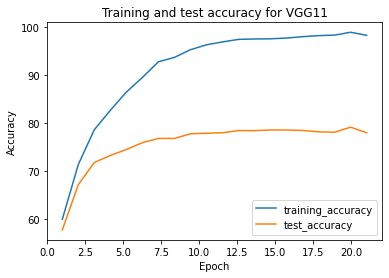

In [9]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_result.jpg')

In [10]:
training_acc

[60.018,
 71.396,
 78.626,
 82.654,
 86.45,
 89.474,
 92.732,
 93.644,
 95.242,
 96.258,
 96.86,
 97.386,
 97.472,
 97.508,
 97.662,
 97.95,
 98.166,
 98.276,
 98.87,
 98.226]

In [11]:
test_acc

[57.81,
 67.21,
 71.82,
 73.28,
 74.51,
 75.93,
 76.82,
 76.81,
 77.78,
 77.89,
 77.99,
 78.45,
 78.42,
 78.58,
 78.56,
 78.47,
 78.18,
 78.1,
 79.15,
 77.99]